# 04_comparacion_precios.ipynb

## Comparación entre precios estimados y precios reales
Este notebook realiza una comparación entre los precios calculados con el sistema generado en `01_calculo_precios.ipynb` y los precios estimados mediante el modelo de Machine Learning en `03_prediccion_precios.ipynb`.
delo.


In [1]:
# Importar las librerías
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 1. Cálculo del precio real de nuevas piezas
Calculamos el precio real de 'nuevas_piezas.csv' mediante el sistema automatizado.

In [2]:
# Cargar piezas nuevas
df_nuevas = pd.read_csv("nuevas_piezas.csv", sep=';')

# Cargar tarifas
df_tarifas = pd.read_excel("tarifas_costes.xlsx", sheet_name=None)
df_materiales = df_tarifas["Materiales"]
df_maquinas = df_tarifas["Maquinas"]
df_costes_adicionales = df_tarifas["Costes Adicionales"]

# Asignar precios y parámetros
materiales_precio_scrap = dict(zip(df_materiales['material'], zip(df_materiales['precio_material'], df_materiales['scrap'])))
maquinas_tarifas = dict(zip(df_maquinas['tonelaje_maquina'], df_maquinas['tarifa_maquina']))
tarifa_manobra = df_costes_adicionales['tarifa_manobra'].iloc[0]
margen_comercial = df_costes_adicionales['margen_comercial'].iloc[0]

# Calcular precio real
df_nuevas['precio_material'] = df_nuevas['material'].map(lambda x: materiales_precio_scrap[x][0])
df_nuevas['scrap'] = df_nuevas['material'].map(lambda x: materiales_precio_scrap[x][1])
df_nuevas['tarifa_maquina'] = df_nuevas['tonelaje_maquina'].map(maquinas_tarifas)
df_nuevas['coste_material'] = df_nuevas['peso_(kg)'] * df_nuevas['precio_material']
df_nuevas['coste_material_con_scrap'] = df_nuevas['coste_material'] * (1 / (1 - df_nuevas['scrap']))
df_nuevas['coste_maquina'] = df_nuevas['tarifa_maquina'] * (df_nuevas['tiempo_ciclo_(s)'] / 3600) / df_nuevas['numero_cavidades']
df_nuevas['coste_manobra'] = tarifa_manobra * (df_nuevas['tiempo_ciclo_(s)'] / 3600)
df_nuevas['coste_total'] = df_nuevas['coste_material_con_scrap'] + df_nuevas['coste_maquina'] + df_nuevas['coste_manobra']
df_nuevas['precio_real'] = (df_nuevas['coste_total'] * (1 + margen_comercial)).round(4)


### 2. Comparación de precios y cálculo de métricas de error
Comparamos los precios estimados con los reales y calculamos las métricas y el error absoluto.

In [3]:
# Cargar predicciones
df_estimado = pd.read_csv("nuevas_piezas_con_precios.csv", sep=';')

# Comparar precios
df_comparado = df_nuevas.merge(df_estimado[['referencia', 'precio_estimado']], on='referencia')
df_comparado['error_abs'] = abs(df_comparado['precio_real'] - df_comparado['precio_estimado'])

# Calcular métricas
mae = mean_absolute_error(df_comparado['precio_real'], df_comparado['precio_estimado'])
rmse = mean_squared_error(df_comparado['precio_real'], df_comparado['precio_estimado'], squared=False)
r2 = r2_score(df_comparado['precio_real'], df_comparado['precio_estimado'])

print("Los valores de las métricas de comparación son:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")


Los valores de las métricas de comparación son:
MAE  = 0.6112
RMSE = 0.7057
R²   = 0.9928


In [4]:
# Mostrar tabla comparativa
df_comparado[['referencia', 'descripcion', 'precio_real', 'precio_estimado', 'error_abs']]


,referencia,descripcion,precio_real,precio_estimado,error_abs
0,REF201,Pieza TEST A,7.1565,6.4008,0.7557
1,REF202,Pieza TEST B,2.1612,2.2638,0.1026
2,REF203,Pieza TEST C,9.8564,10.4536,0.5972
3,REF204,Pieza TEST D,22.0938,20.9567,1.1371
4,REF205,Pieza TEST E,13.0775,11.9155,1.1620
5,REF206,Pieza TEST F,3.1587,3.8079,0.6492
6,REF207,Pieza TEST G,4.3800,5.0948,0.7148
7,REF208,Pieza TEST H,13.3937,12.8148,0.5789
8,REF209,Pieza TEST I,29.9321,29.8759,0.0562
9,REF210,Pieza TEST J,12.8283,13.1865,0.3582


### 3. Visualización de la comparación
Visualizamos en un gráfico los precios reales y estimados de cada pieza para comparar

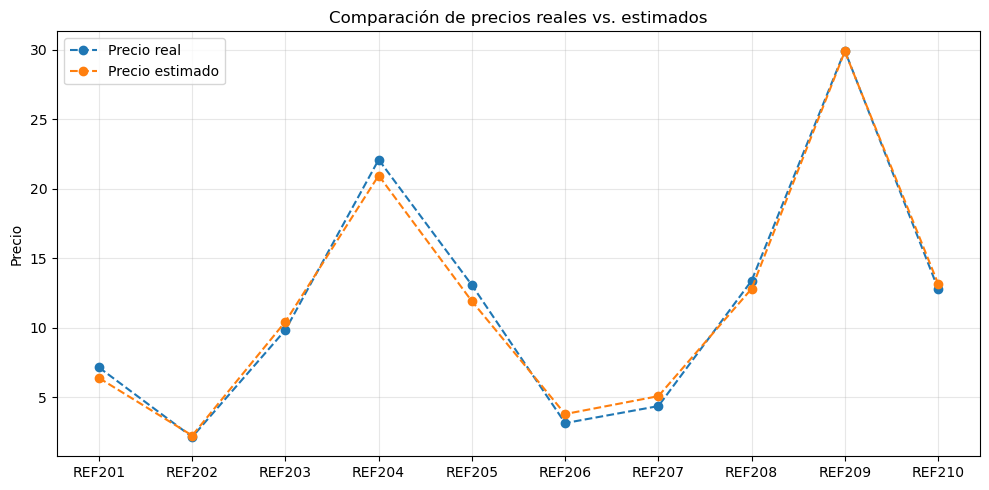

In [5]:
# Visualizar precios reales y estimados
plt.figure(figsize=(10, 5))
plt.plot(df_comparado['referencia'], df_comparado['precio_real'], marker='o', label='Precio real', linestyle='--')
plt.plot(df_comparado['referencia'], df_comparado['precio_estimado'], marker='o', label='Precio estimado', linestyle='--')
plt.ylabel("Precio")
plt.title("Comparación de precios reales vs. estimados")
plt.legend()
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

### 4. Exportar resultado combinado
Se guarda el resultado de la comparación en un nuevo archivo CSV.

In [6]:
# Exportar .csv con resultados
columnas_salida = df_comparado.columns[:7].tolist() + ['precio_real', 'precio_estimado', 'error_abs']
df_comparado[columnas_salida].to_csv("comparacion_precios.csv", sep=';', index=False)
print("El archivo 'comparacion_precios.csv' se ha exportado correctamente.")

El archivo 'comparacion_precios.csv' se ha exportado correctamente.
